# __Importing Libraries__

In [25]:
#Basic Libraries
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import os.path
import os
import regex as re
import warnings
import cv2
import math
import zipfile
import itertools
warnings.filterwarnings('ignore')


#Preprocessing and Modeliing Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, AveragePooling2D, Input, Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# __Data Preprocessing and Transformation__

In [27]:
infected_path = '/content/drive/MyDrive/cell_images/Parasitized'
uninfected_path = '/content/drive/MyDrive/cell_images/Uninfected'

In [28]:
Pimages = os.listdir(infected_path)
Nimages = os.listdir(uninfected_path)

In [29]:

data = []
labels = []

# Load images from Parasitized directory
parasitized_dir = "/content/drive/MyDrive/cell_images/Parasitized"
Parasitized = os.listdir(parasitized_dir)
for a in Parasitized:
    try:
        image_path = os.path.join(parasitized_dir, a)
        image = cv2.imread(image_path)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

# Load images from Uninfected directory
uninfected_dir = "/content/drive/MyDrive/cell_images/Uninfected"
Uninfected = os.listdir(uninfected_dir)
for b in Uninfected:
    try:
        image_path = os.path.join(uninfected_dir, b)
        image = cv2.imread(image_path)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")


In [30]:
data=np.array(data)
labels=np.array(labels)

In [31]:
s=np.arange(data.shape[0])
np.random.shuffle(s)
data=data[s]
labels=labels[s]

In [32]:
num_classes=len(np.unique(labels))
len_data=len(data)

(x_train,x_test)=data[(int)(0.1*len_data):],data[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [33]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [34]:
print(y_train.shape)


(24858,)


In [35]:
#Do Onehot encoding as classifier has multiple classes
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

In [36]:
y_train.shape

(24858, 2)

# __Model Building__



In [37]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        416       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 12, 12, 32)       

In [38]:
#Prepare model save directory
save_dir = os.path.join(os.getcwd(), 'model')
model_name = 'malaria_calssifier_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)

In [39]:
#Callbacks
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
h=model.fit(x_train,y_train,
            batch_size=32,callbacks=callbacks,
            validation_data=(x_test,y_test),epochs=20,verbose=1)

Epoch 1/20
777/777 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8230
Epoch 1: val_accuracy improved from -inf to 0.95581, saving model to /content/model/malaria_calssifier_model.h5
777/777 [==============================] - 20s 7ms/step - loss: 0.3622 - accuracy: 0.8230 - val_loss: 0.1586 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 2/20
773/777 [============================>.] - ETA: 0s - loss: 0.1743 - accuracy: 0.9482
Epoch 2: val_accuracy improved from 0.95581 to 0.96161, saving model to /content/model/malaria_calssifier_model.h5
777/777 [==============================] - 5s 6ms/step - loss: 0.1740 - accuracy: 0.9483 - val_loss: 0.1441 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 3/20
774/777 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9516
Epoch 3: val_accuracy did not improve from 0.96161
777/777 [==============================] - 6s 7ms/step - loss: 0.1573 - accuracy: 0.9515 - val_loss: 0.1371 - val_accuracy: 0.9605 - lr: 0.0010
E

# __Model Evaluation__

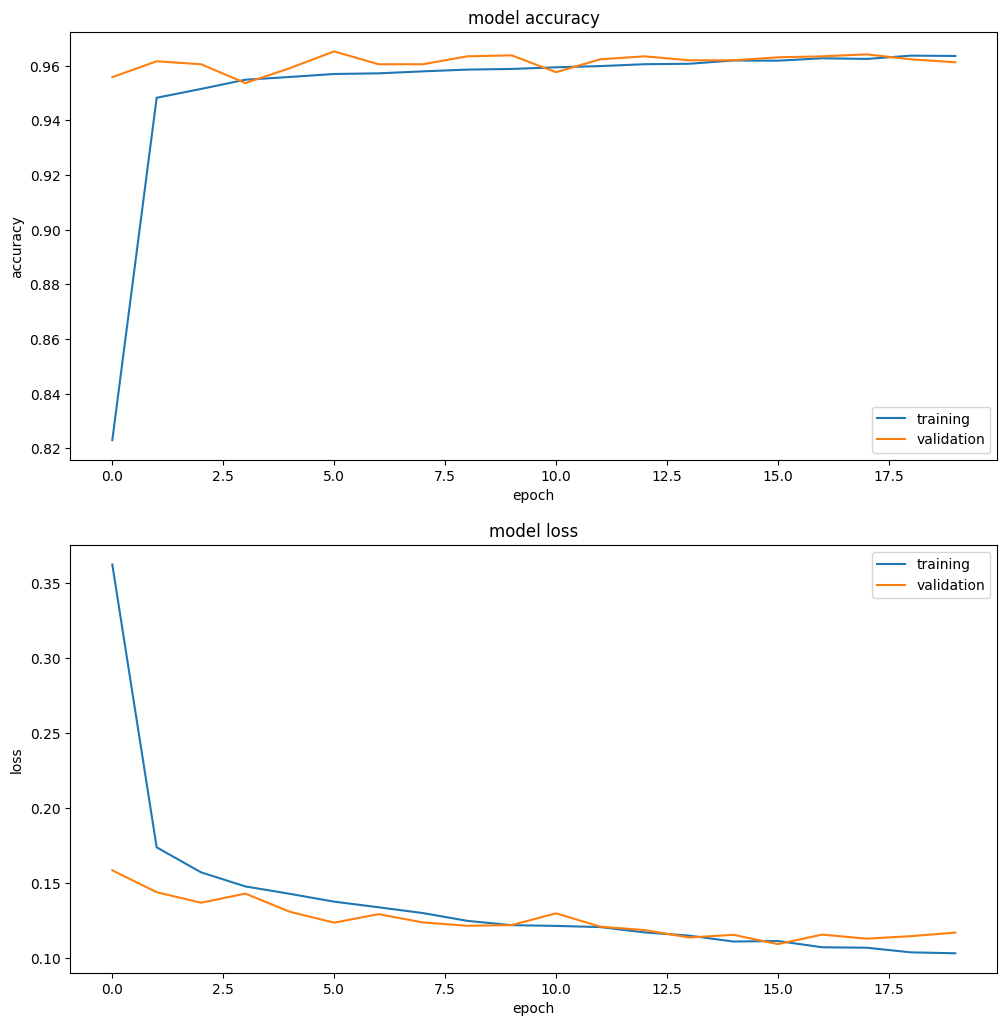

In [41]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(h.history['accuracy'], h.history['val_accuracy'], 'accuracy', 211)
display_training_curves(h.history['loss'], h.history['val_loss'], 'loss', 212)

In [42]:
model = load_model('/content/model/malaria_calssifier_model.h5')

In [43]:
score=model.evaluate(x_test,y_test)
print(score)

87/87 [==============================] - 0s 3ms/step - loss: 0.1238 - accuracy: 0.9652
[0.12381598353385925, 0.9652299880981445]


87/87 [==============================] - 0s 2ms/step


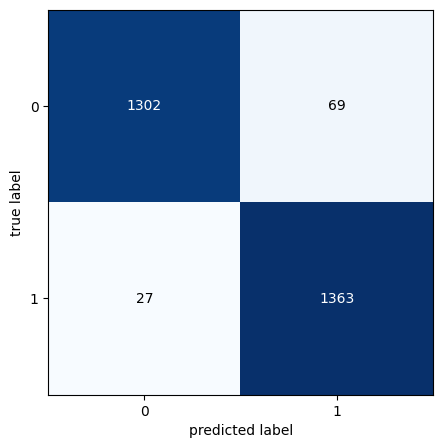

In [44]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1)
y_true = np.argmax(y_test,axis = 1)

CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [45]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
malaria_labels = ['Parasitized','Uninfected']

87/87 [==============================] - 0s 2ms/step


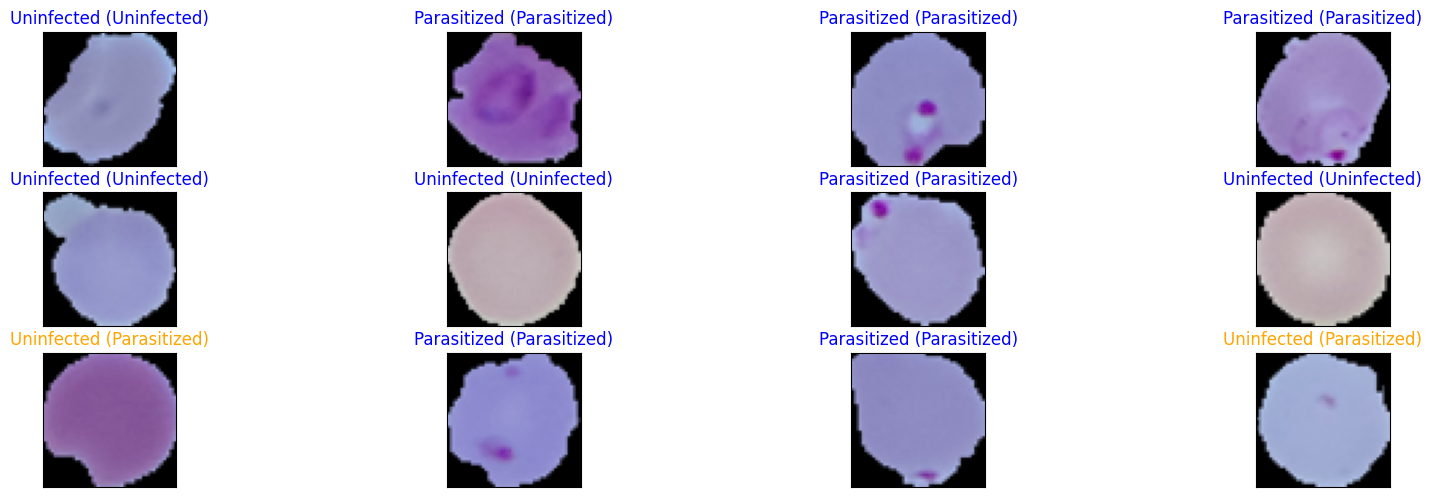

In [46]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

# __Model Explanaiblity Using LIME__

In [52]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4c92e4eb370d9137cdcf8edcbce83c3a45fddb66a571daee53839448767f6b73
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


1/1 [==============================] - 0s 19ms/step
Malaria Parasitized


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


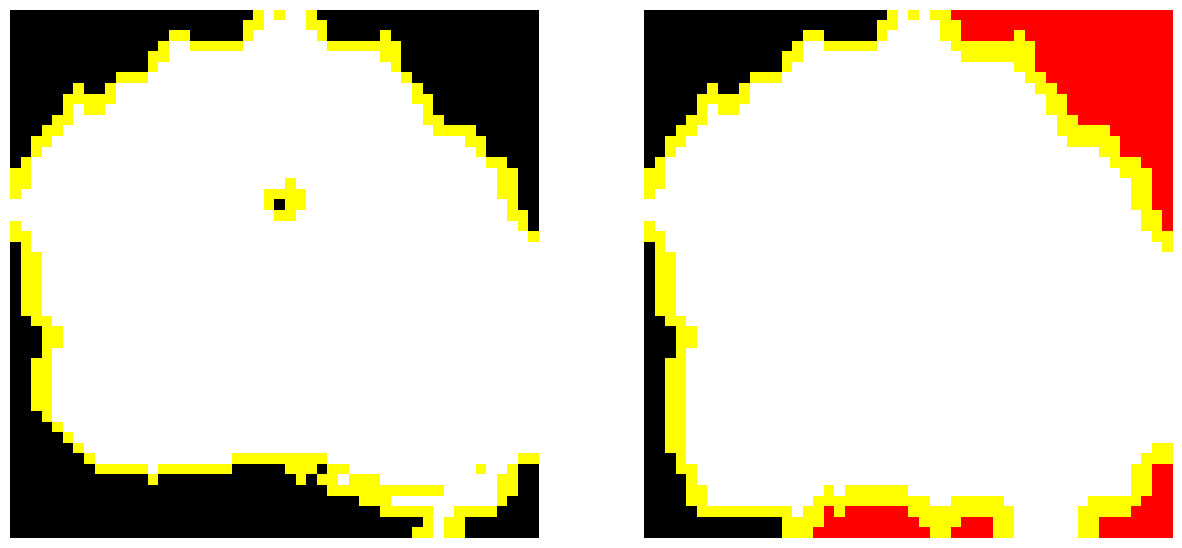

In [56]:
from lime import lime_image
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Function to print the prediction of an image
def model_predict(img_path, model):
    img = load_img(img_path, target_size=(50, 50))  # target_size must agree with what the trained model expects!!
    # Preprocessing the image
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)
    pred = np.argmax(preds, axis=1)
    str1 = 'Malaria Parasitized'
    str2 = 'Normal'
    if pred[0] == 0:
        return str1
    else:
        return str2

# Function to read and transform images from path
def read_and_transform(image_path):
    img = load_img(image_path, target_size=(50, 50))  # target_size must agree with what the trained model expects!!
    # Preprocessing the image
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Using lime to explain the model prediction
def explain_prediction(image_path, model):
    image = read_and_transform(image_path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image[0].astype('double'), model.predict, top_labels=2, hide_color=0, num_samples=1000)

    # Create masks
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    # Display images with masks
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')
    plt.show()

# Example usage
random_image = '/content/drive/MyDrive/cell_images/Parasitized/C33P1thinF_IMG_20150619_115808a_cell_205.png'
print(model_predict(random_image, model))
explain_prediction(random_image, model)


__Observations:__


__No Overfitting:__

The absence of overfitting is a positive observation. Overfitting occurs when a model learns the training data too well, including its noise and outliers, to the extent that it performs poorly on unseen data. A lack of overfitting suggests that the model generalizes well to new, unseen data. This is a crucial aspect of model performance, ensuring that it doesn't memorize the training set but learns patterns that can be applied to different samples.

High Accuracy:
An accuracy score of 96.52% on the test dataset is a notable achievement. This indicates that the model is making correct predictions for the majority of the test samples. However, it's important to consider the class distribution in the dataset. If the classes are imbalanced (e.g., more samples of one class than the other), accuracy alone might not provide a complete picture. It's recommended to also evaluate precision, recall, and F1-score, especially in medical applications where the cost of false positives or false negatives can vary.

__Correct Identification of Images:__
The observation that the model is able to identify most of the images correctly is a positive sign of its effectiveness. It suggests that the features learned during training are relevant and discriminative for distinguishing between infected and uninfected cells. Visual inspection of a subset of predictions, along with their ground truth labels, can provide insights into the model's strengths and potential areas for improvement.

__Confusion Matrix and Class-wise Metrics:__
To gain a more detailed understanding of the model's performance, consider generating a confusion matrix. This matrix provides a breakdown of true positives, true negatives, false positives, and false negatives. From this, you can compute precision, recall, and F1-score for each class. These metrics can be particularly important in medical applications, where the consequences of false positives and false negatives can vary.

__Threshold Tuning:__
Depending on the application, you might explore tuning the classification threshold. The default threshold for binary classification is often 0.5, but adjusting it can impact the trade-off between sensitivity and specificity. In medical diagnosis, you may want to prioritize sensitivity (recall) to reduce false negatives, even at the cost of increased false positives.

__Visualizing Model Predictions:__
Consider visualizing model predictions on a subset of the test dataset. This can help identify specific patterns or types of images where the model may struggle. Techniques like Grad-CAM (Gradient-weighted Class Activation Mapping) can highlight the regions in the input images that are most influential in the model's decision-making process.

__Model Interpretability:__
In medical applications, it's important to have interpretable models. Consider using techniques like LIME (Local Interpretable Model-agnostic Explanations) or SHAP (SHapley Additive exPlanations) to explain individual predictions. This can enhance trust in the model's decisions, especially in critical domains like healthcare.in the above i used LIME.